In [242]:
# -------------------------------------------------- #
# EEG Classification Using Convolutional Neural Networks
# Jose Garcia
# Runninging in Windows OS\
# -------------------------------------------------- #

# Import libraries
#
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

# MNE
import mne

# Pytorch
import torch.nn.functional as F
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

# Plot configuration - Using scientific library
plt.style.use(['science','grid'])


# Goal
Model to classify motor imagery tasks,

# 0. Exploratory Data Analysis

EEG Data related to Motor Imagery commands. Please go to References to read the paper related to the data

In [2]:
# Data reading
# EOG channels name
eog_channels = ['EOG-left', 'EOG-central', 'EOG-right']

# Loading first subject to familirize with the data
dataset=mne.io.read_raw_gdf(r'..\data\BCICIV_2a_gdf\A01T.gdf',
                         eog=eog_channels)

# Split EEG and EOG
dataset_eeg = dataset.copy().pick_types(eeg=True)
dataset_eog = dataset.copy().pick_types(eog=True)


Extracting EDF parameters from C:\Users\josea\Desktop\SS2023\Hunting fot Hedonia\Ceregate\CereGate - ML-DL Technical Assessment\data\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


c:\users\josea\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\josea\appdata\local\programs\python\python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


In [3]:
# Understanding Events
events=mne.events_from_annotations(dataset_eeg)
print(events[1])

# Create own event dataframe and mapping the data based on the experiment
events_labels = [276,277,768,769,770,771,772,1023,1072,32766]
event_description = ['Eyes open', 'Eyes closed', 'Start trial','class_1','class_2','class_3','class_4',\
                     'Rejected', 'Eye movements', 'New run']
local_anotation = [3,4,6,7,8,9,10,1,2,5]
data = {'Events': events_labels,
        'Description': event_description,
        'Annotations': local_anotation}
events_df = pd.DataFrame(data)
events_df.sort_values("Annotations")



Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}


,Events,Description,Annotations
7,1023,Rejected,1
8,1072,Eye movements,2
0,276,Eyes open,3
1,277,Eyes closed,4
9,32766,New run,5
2,768,Start trial,6
3,769,class_1,7
4,770,class_2,8
5,771,class_3,9
6,772,class_4,10


The previous table shows what means each event based on the dataset info

#### Epoching

In a first stage of the proposal the epoching will be done just for the windows where the motor imagery actions were executed. Meaning that I will only take the data label with the events id of 7, 8, 9 and 10. See event table above

In [210]:
# Create Epoch just for the event where the subject is executing one action
epochs = mne.Epochs(dataset_eeg, events[0], event_id=[7,8,9,10],  preload=True)
epochs.get_data().shape

Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 288 events and 176 original time points ...
0 bad epochs dropped


(288, 22, 176)

It can be seen 288 trials, 22 electrodes, 176 points per trial. 
288 comes from: 2 sessions, 6 run per session, each run has 48 trials,  12 trials per command ( 4 commands )


### Time domain inspection

I would like to see the signals (average)

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


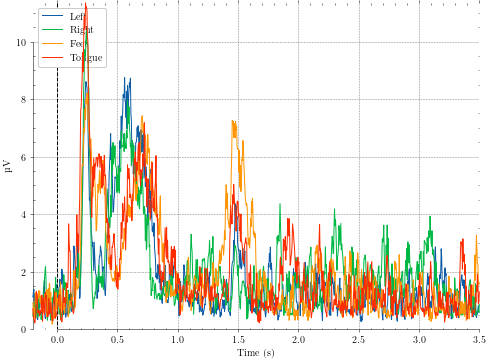

[<Figure size 576x432 with 1 Axes>]

In [5]:
# Created the evokes (epochs during training)
evoked_class0 = epochs['7'].average()
evoked_class1 = epochs['8'].average()
evoked_class2 = epochs['9'].average()
evoked_class3 = epochs['10'].average()

#left,right,foot,tongue
dicts={'Left':evoked_class0,'Right':evoked_class1,'Feet':evoked_class2,'Tongue':evoked_class3}
mne.viz.plot_compare_evokeds(dicts)

Based on the experiment the time window where the subject is executing the movement is 3s, but I can see that after 2s there is a mostly noise. The frequency analysis will probably show a similar figure but a bit smother if I cut the min and max time when epoching is done.

### Frequency domain inspection

I would like to see the signals in the frequency with the PDS (power density spectrum)

    Using multitaper spectrum estimation with 7 DPSS windows


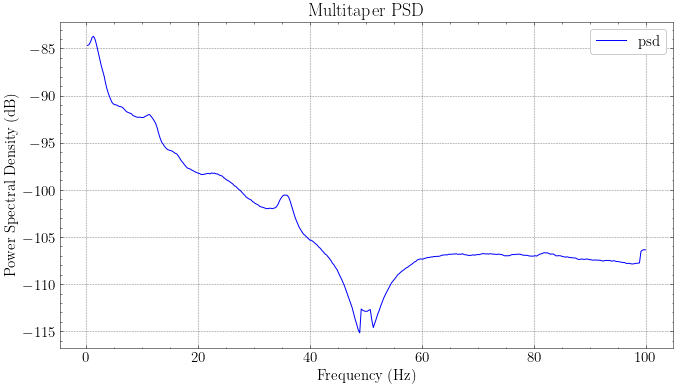

In [6]:
# Generate the X matrix
X = epochs.get_data()

def psd_plus_plit(X):
    """
    Calculate the PSD of the input dataset and plot the psd in the frequency domain
    Args:
        X (np array): Train feature dataset
    Returns:
        None
    """
    # Calculate the psds
    psds, freqs = mne.time_frequency.psd_array_multitaper(X, sfreq=dataset.info['sfreq'],
                                                              fmin=0.1, fmax=100)
    # Scale the results to be dB
    psds = 10*np.log10(psds)
    psds_mean = psds.mean(0).mean(0)

    # Plot the PSD
    plt.rcParams['figure.figsize']=[11,6]
    plt.rcParams.update({'font.size': 15})
    _, ax = plt.subplots()
    ax.plot(freqs, psds_mean, color='blue', label='psd')
    # plot_psd(X, ax, 'original', 'k')

    ax.set(title='Multitaper PSD', xlabel='Frequency (Hz)',
           ylabel='Power Spectral Density (dB)')
    ax.legend()
    
    plt.show()
    
psd_plus_plit(X)

EEG data bands are from 0.5Hz until 30Hz aprox. This means that frequencies above 40Hz are not of our interest. This filter allow me to filter as well the 50Hz.

Below 7Hz the EEG bands do not correspond to Motor imagery and are bands more related to sleep and deep sleep. That is why a filter from 7Hz until 35Hz is used.


In [7]:
# Apply filter between 7Hz and 35Hz. 
X_filtered = mne.filter.filter_data(X, dataset.info['sfreq'], 7, 35)

Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6336 out of 6336 | elapsed:    1.3s finished


    Using multitaper spectrum estimation with 7 DPSS windows


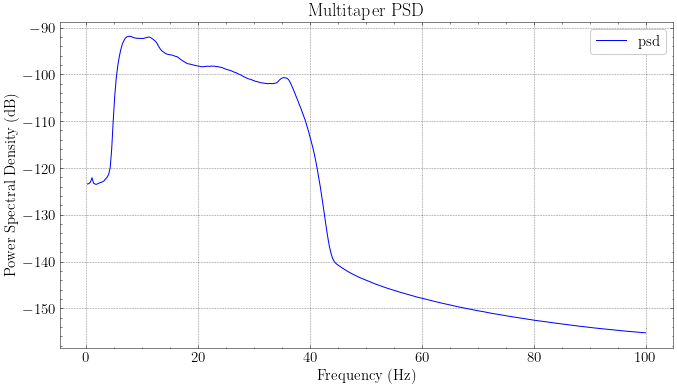

In [8]:
psd_plus_plit(X_filtered)

From the plot we can see that the epoching could be done from -0.15s until 0.8s

I will try to reduce the time frame to erase unnecessary noise, by creating the epochs between -0.15s and 1.8s

Not setting metadata
288 matching events found
Setting baseline interval to [-0.152, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 288 events and 489 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=1)]: Done 6336 out of 6336 | elapsed:    0.8s finished


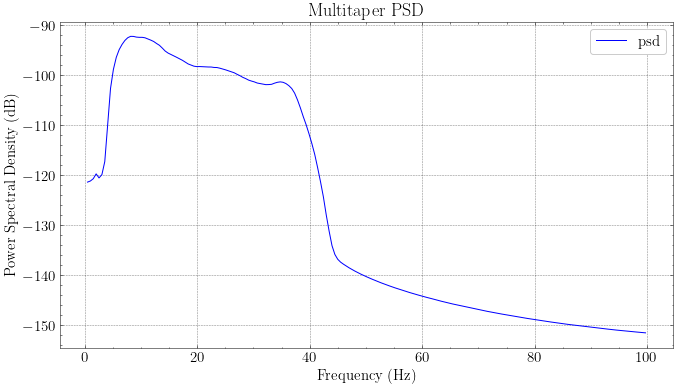

In [9]:
# Apply tmin and tmax to short the feature data
epochs_shorter = mne.Epochs(dataset_eeg, events[0], event_id=[7,8,9,10],tmin= -0.15, tmax=1.8, preload=True)

# Generate the feature matrix
X_shorter = epochs_shorter.get_data()

# Apply previous filter
X_filtered_short = mne.filter.filter_data(X_shorter, dataset.info['sfreq'], 7, 35)

# Calculate and plot frequency domain, PDS
psd_plus_plit(X_filtered_short)

#### Check empty data

In [10]:
np.isnan(X_filtered_short).sum()

0

No need to eliminate empty trials

#### Looking for REF electrode

In [11]:
print(dataset.info['ch_names'])
print(dataset.info['sfreq'])

['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16', 'EOG-left', 'EOG-central', 'EOG-right']
250.0


There is not reference electrode in the data. Re-referencing must be done based on average.

#### Check Validation dataset

In [12]:
# Loading first subject to familirize with the data
dataset_evaluation=mne.io.read_raw_gdf(r'..\data\BCICIV_2a_gdf\A01E.gdf', eog=eog_channels)
events_evaluation_dataset=mne.events_from_annotations(dataset_evaluation)
print(events[1])

Extracting EDF parameters from C:\Users\josea\Desktop\SS2023\Hunting fot Hedonia\Ceregate\CereGate - ML-DL Technical Assessment\data\BCICIV_2a_gdf\A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}


c:\users\josea\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\josea\appdata\local\programs\python\python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


As we can see, the evaluation dataset cant be used for the either testing or validation because these dataset do not have labels, see in 'annotations description' there is no code: 769, 770, 771, 772. There are the labels for the classes. 
I  will only work with the Training datasets and will split that one.

### Conclusions from the EDA

- Balanced dataset. Each class 288 trials, at least the first subject. Subject 4 is shorter.
- No Empty values, for at leat the first dataset
- No need to encoding features or labels. All the columns are numbers.
- Need to re-referencing the signal, for this case, due to the abscense of the referene electrode in the data, will the average 
- Based on the time domain analysis, the signal will be shorted from -0.15s until 1.7s
- Based on the frequency domain analysis at least a filter from 7Hz until 35Hz should be evaluate in the pre-processing section

# 1. Data Preprocessing

Data will be read and the join in one dataset. The filter will be applied and then the dataset will be Split in a proportion of:
- 70% Training
- 20% Validation
- 10% Testing    



In [221]:
# Function to read all the datasets

eog_channels = ["EOG-left", "EOG-central", "EOG-right"]

def loading_data(path):
    """
    Load all the gdf train datasets
    Args:
        path (string): Path to the folder locations of the files
    Returns:
        X_train (array) : Array of features
        y_train (array): Array of labels
    """
    
    
    print(path)
    dataset_raw=mne.io.read_raw_gdf(path, eog=eog_channels,  preload=True )
    
    # Split EEG and EOG
    dataset_eeg = dataset_raw.copy().pick_types(eeg=True)
    dataset_eog = dataset_raw.copy().pick_types(eog=True)

    # Re-reference ref_channels='average'
    dataset_eeg.set_eeg_reference(ref_channels='average')
    
    # Epoching based on the 
    events = mne.events_from_annotations(dataset_eeg)
    epochs = mne.Epochs(dataset_eeg, events[0], event_id=[7,8,9,10], on_missing ='warn')
    y_train = epochs.events[:,-1]
    X_train = epochs.get_data()
    return X_train , y_train


X = []
y = [] 

for i in range(1,10):
    X_train_partial,y_train_partial = loading_data(f'..\data\BCICIV_2a_gdf\A0{i}T.gdf')
    X.append(X_train_partial)
    y.append(y_train_partial)
    
X_ = np.concatenate(X)
y_ = np.concatenate(y)

..\data\BCICIV_2a_gdf\A01T.gdf
Extracting EDF parameters from C:\Users\josea\Desktop\SS2023\Hunting fot Hedonia\Ceregate\CereGate - ML-DL Technical Assessment\data\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


c:\users\josea\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\josea\appdata\local\programs\python\python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
..\data\BCICIV_2a_gdf\A02T.gdf
Extracting EDF parameters from C:\Users\josea\Desktop\SS2023\Hunting fot Hedonia\Ceregate\CereGate - ML-DL Technical Assessment\data\BCICIV_2a_gdf\A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 677168  =      0.000 ... 

c:\users\josea\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\josea\appdata\local\programs\python\python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
..\data\BCICIV_2a_gdf\A03T.gdf
Extracting EDF parameters from C:\Users\josea\Desktop\SS2023\Hunting fot Hedonia\Ceregate\CereGate - ML-DL Technical Assessment\data\BCICIV_2a_gdf\A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ... 

c:\users\josea\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\josea\appdata\local\programs\python\python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
..\data\BCICIV_2a_gdf\A04T.gdf
Extracting EDF parameters from C:\Users\josea\Desktop\SS2023\Hunting fot Hedonia\Ceregate\CereGate - ML-DL Technical Assessment\data\BCICIV_2a_gdf\A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ... 

c:\users\josea\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\josea\appdata\local\programs\python\python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 176 original time points ...
0 bad epochs dropped
..\data\BCICIV_2a_gdf\A05T.gdf
Extracting EDF parameters from C:\Users\josea\Desktop\SS2023\Hunting fot Hedonia\Ceregate\CereGate - ML-DL Technical Assessment\data\BCICIV_2a_gdf\A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs

<ipython-input-221-4b7464a67db9>:28: RuntimeWarning: No matching events found for 9 (event id 9)
  epochs = mne.Epochs(dataset_eeg, events[0], event_id=[7,8,9,10], on_missing ='warn')
<ipython-input-221-4b7464a67db9>:28: RuntimeWarning: No matching events found for 10 (event id 10)
  epochs = mne.Epochs(dataset_eeg, events[0], event_id=[7,8,9,10], on_missing ='warn')
c:\users\josea\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\josea\appdata\local\programs\python\python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
..\data\BCICIV_2a_gdf\A06T.gdf
Extracting EDF parameters from C:\Users\josea\Desktop\SS2023\Hunting fot Hedonia\Ceregate\CereGate - ML-DL Technical Assessment\data\BCICIV_2a_gdf\A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 678979  =      0.000 ... 

c:\users\josea\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\josea\appdata\local\programs\python\python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
..\data\BCICIV_2a_gdf\A07T.gdf
Extracting EDF parameters from C:\Users\josea\Desktop\SS2023\Hunting fot Hedonia\Ceregate\CereGate - ML-DL Technical Assessment\data\BCICIV_2a_gdf\A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ... 

c:\users\josea\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\josea\appdata\local\programs\python\python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
..\data\BCICIV_2a_gdf\A08T.gdf
Extracting EDF parameters from C:\Users\josea\Desktop\SS2023\Hunting fot Hedonia\Ceregate\CereGate - ML-DL Technical Assessment\data\BCICIV_2a_gdf\A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 675269  =      0.000 ... 

c:\users\josea\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\josea\appdata\local\programs\python\python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped
..\data\BCICIV_2a_gdf\A09T.gdf
Extracting EDF parameters from C:\Users\josea\Desktop\SS2023\Hunting fot Hedonia\Ceregate\CereGate - ML-DL Technical Assessment\data\BCICIV_2a_gdf\A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ... 

c:\users\josea\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\josea\appdata\local\programs\python\python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...
0 bad epochs dropped


In [407]:
# Check empty values
print(X_.shape, y_.shape)
print('Empty Trials: ', np.isnan(X_).sum())

(2448, 22, 176) (2448,)
Empty Trials:  0


In [408]:
# Apply filter between 7Hz and 35Hz. 
X_filtered = mne.filter.filter_data(X_, dataset.info['sfreq'], 7, 35)

Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 sec)



<ipython-input-408-14b14d1f2d1b>:2: RuntimeWarning: filter_length (413) is longer than the signal (176), distortion is likely. Reduce filter length or filter a longer signal.
  X_filtered = mne.filter.filter_data(X_, dataset.info['sfreq'], 7, 35)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 53856 out of 53856 | elapsed:    9.2s finished


In [224]:
# Split the dataset
train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10

# Due to the annotations the classses are 7,8,9,10. I have to mapp it to 0,1,2,3
y_ = np.where(y_ >= 7, y_ - 7, y_)

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_, test_size = 1 - train_ratio, random_state=42)
                                                    
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print('X_train size ', X_train.shape, 'X_val size ', X_val.shape, 'X_test size ', X_test.shape,)


X_train size  (1713, 22, 176) X_val size  (490, 22, 176) X_test size  (245, 22, 176)


## Partial Conclusions
- As discussed in the EDA sections there was applyed:
    - Re-referencing with the average of the 22 electrodes
    - Band Pass filter applied between 7Hz and 35Hz
    - Time window applied between -0.15s and 1.8s
    - Epoching applied with the labels related just with the motor imagery commands

# 2. Model Development

A CNN will be implemented integrated by several layers with:
- 1D Convolutional layer
- ReLU as activation function
- 1D Max Pool

The amount of layer will be consider depending of the vase of either underfittig (Add more) o overfitting (Use regularization methods)

In [523]:
# Define the architecture

class CNN_Model(nn.Module):
    def __init__(self, output_size,  dropout):
        
        # Definition of the model
        # 5 layers with a final fully connected network
        
        super(CNN_Model, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=22, out_channels=20, kernel_size=3, stride= 1, padding = 0)
        nn.Dropout(p=dropout)
        self.pool1 = nn.MaxPool1d(kernel_size= 9, stride =1)
#         self.batch_n1 = nn.BatchNorm1d(20, affine=False)
        self.drop_ = nn.Dropout(p=dropout)
        
        self.conv2 = nn.Conv1d(in_channels=20, out_channels=10, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride = 1)
#         self.batch_n2 = nn.BatchNorm1d(10, affine=False)
        self.drop_ = nn.Dropout(p=dropout)
        
        self.conv3 = nn.Conv1d(in_channels=10, out_channels=5, kernel_size=3, stride=2)
        self.pool3 = nn.MaxPool1d(kernel_size=3, stride = 1)
#         self.batch_n3 = nn.BatchNorm1d(5, affine=False)
        self.drop_ = nn.Dropout(p=dropout)
        
        self.conv4 = nn.Conv1d(in_channels=5, out_channels=5, kernel_size=3, stride=2)
        self.pool4 = nn.MaxPool1d(kernel_size=3, stride = 1)
        
        self.fc1 = nn.Linear(5*38, output_size)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
#         print("input: ", x[0].shape)
        x = self.pool1(x)
#         print("input: ", x[0].shape)
#         x = self.batch_n1(x)
        x = self.drop_(x)
    
        x = F.relu(self.conv2(x))
#         print("input: ", x[0].shape)
        x = self.pool2(x)
#         print("input: ", x[0].shape)
#         x = self.batch_n2(x)
        x = self.drop_(x)
        
        
        x = F.relu(self.conv3(x))
#         print("input: ", x[0].shape)
        x = self.pool3(x)
#         print("input: ", x[0].shape)
#         x = self.batch_n3(x)
        x = self.drop_(x)
        
        
        x = F.relu(self.conv4(x))
        x = self.drop_(x)
        
#         print("input: ", x[0].shape)

        x = x.reshape(x.shape[0], -1)
#         print("input: ", x[0].shape)
        x = self.fc1(x)
#         print("out: ", x[0].shape)

        return x

Define hyperparameters of the network:
- Output are 4, which means that Cross Entropy loss function could be the best idea for this case
- Learning rate as 0.001, this parameter may change
- Epochs 100, to start
- Batch size of 64
- Optimizer: Adam

In [531]:
# Define the hyperparameters
# input_size = 6  # Size of input features
output_size = 4  # Number of output classes
learning_rate = 0.001  # Learning rate
num_epochs = 100  # Number of training epochs
batch_size = 64 # Batch size for mini-batch SGD


# Instantiate the CNN model
model = CNN_Model(output_size, dropout = 0.1).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


print(X_train.shape)

(1713, 22, 176)


In [532]:
# Creating tensor loaders
train_features_tensor = torch.tensor(X_train, dtype=torch.float32)
train_labels_tensor = torch.tensor(y_train, dtype=torch.float32)

val_features_tensor = torch.tensor(X_val, dtype=torch.float32)
val_labels_tensor = torch.tensor(y_val, dtype=torch.float32)

test_features_tensor = torch.tensor(X_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(train_features_tensor, train_labels_tensor)
val_dataset = torch.utils.data.TensorDataset(val_features_tensor, val_labels_tensor)
test_dataset = torch.utils.data.TensorDataset(test_features_tensor, test_labels_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [533]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if dev.type == 'cuda':
   print('Your GPU device name :', torch.cuda.get_device_name())

Your GPU device name : NVIDIA GeForce RTX 3060 Laptop GPU


# 3. Training and Evaluation

After defining the model we need 2 functions:
- To train (train_epoch)
- To evaluate and calculate accuracy and loss (valid_epoch)

In [534]:
def train_epoch(model, device,dataloader, criterion, optimizer):
    """
    Train the model based on some arguments
    Args:
        model (pytorch model): Model defined prev
        device: required to process on GPU
        dataloader: the input dataloader
        criterion: Loss function
        optimizer: Optimizer
    Returns:
        train_loss (np array): Cumulative losses per epoch
        train_correct (np array):  Cumulative correct predictions per epoch
    """
    
    train_loss, train_correct = 0.0, 0
    model.train()
    for i, (signal, labels) in enumerate(dataloader):
        
        labels = labels.long()          
        signal, labels = signal.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(signal)
        loss = criterion(outputs,labels)     
        
        # Backward and optimize
        optimizer.zero_grad()     
        loss.backward()
        optimizer.step()
               
        train_loss += loss.item() * signal.size(0)
        scores, predictions = outputs.max(1)
        train_correct += (predictions == labels).sum().item()        
        
    return train_loss, train_correct
  
def valid_epoch(model, device, dataloader, criterion):
    """
    Evaluate the model based on some arguments
    Args:
        model (pytorch model): Model defined prev
        device: required to process on GPU
        dataloader: the input dataloader
        criterion: Loss function
    Returns:
        valid_loss (np array): Cumulative losses per epoch
        val_correct (np array):  Cumulative correct predictions per epoch
    """
    
    valid_loss, val_correct = 0.0, 0
    total = 0
    model.eval()
    for signal, labels in dataloader:
#         signal = signal.unsqueeze(2).type(torch.FloatTensor)
        labels = labels.long()         
        signal, labels = signal.to(device), labels.to(device)
        
        outputs = model(signal)
        loss = criterion(outputs,labels) 
        
        valid_loss += loss.item() * signal.size(0)
        scores, predictions = outputs.max(1)
        val_correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
    return valid_loss, val_correct

Below you can see the execution of these two functions and the accumulation of the arrangements that will show us the behavior of the cost function and the accuracy

In [535]:
# Train the model

# Small dataset to train
# X_train,  y_train = X_train[:10],  y_train[:10]
# num_epochs  = 5
history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}

for epoch in range(num_epochs):
    train_loss, train_correct = train_epoch(model, device, train_loader, criterion, optimizer)
    val_loss, val_correct = valid_epoch(model, device, val_loader, criterion)

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    val_loss = val_loss / len(val_loader.sampler)
    val_acc = val_correct / len(val_loader.sampler) * 100
    
    print("Epoch:{}/{} || Training Loss:{:.3f} ||Test Loss:{:.3f} || Training Acc {:.2f} % || Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             val_loss,
                                                                                                             train_acc,
                                                                                                         val_acc))
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    

Epoch:1/100 || Training Loss:1.386 ||Test Loss:1.384 || Training Acc 26.39 % || Test Acc 25.71 %
Epoch:2/100 || Training Loss:1.386 ||Test Loss:1.383 || Training Acc 27.20 % || Test Acc 25.71 %
Epoch:3/100 || Training Loss:1.386 ||Test Loss:1.384 || Training Acc 26.04 % || Test Acc 25.71 %
Epoch:4/100 || Training Loss:1.386 ||Test Loss:1.382 || Training Acc 25.39 % || Test Acc 29.59 %
Epoch:5/100 || Training Loss:1.386 ||Test Loss:1.383 || Training Acc 25.86 % || Test Acc 25.71 %
Epoch:6/100 || Training Loss:1.386 ||Test Loss:1.384 || Training Acc 26.91 % || Test Acc 25.71 %
Epoch:7/100 || Training Loss:1.386 ||Test Loss:1.384 || Training Acc 26.56 % || Test Acc 25.71 %
Epoch:8/100 || Training Loss:1.386 ||Test Loss:1.383 || Training Acc 26.97 % || Test Acc 25.71 %
Epoch:9/100 || Training Loss:1.386 ||Test Loss:1.384 || Training Acc 26.50 % || Test Acc 25.71 %
Epoch:10/100 || Training Loss:1.385 ||Test Loss:1.383 || Training Acc 26.91 % || Test Acc 25.71 %
Epoch:11/100 || Training Loss

Epoch:86/100 || Training Loss:1.385 ||Test Loss:1.384 || Training Acc 26.91 % || Test Acc 25.71 %
Epoch:87/100 || Training Loss:1.385 ||Test Loss:1.384 || Training Acc 26.91 % || Test Acc 25.71 %
Epoch:88/100 || Training Loss:1.385 ||Test Loss:1.384 || Training Acc 26.85 % || Test Acc 25.71 %
Epoch:89/100 || Training Loss:1.385 ||Test Loss:1.383 || Training Acc 26.85 % || Test Acc 25.71 %
Epoch:90/100 || Training Loss:1.385 ||Test Loss:1.384 || Training Acc 26.91 % || Test Acc 25.71 %
Epoch:91/100 || Training Loss:1.385 ||Test Loss:1.384 || Training Acc 26.91 % || Test Acc 25.71 %
Epoch:92/100 || Training Loss:1.385 ||Test Loss:1.383 || Training Acc 26.91 % || Test Acc 25.71 %
Epoch:93/100 || Training Loss:1.385 ||Test Loss:1.383 || Training Acc 26.91 % || Test Acc 25.71 %
Epoch:94/100 || Training Loss:1.385 ||Test Loss:1.383 || Training Acc 26.91 % || Test Acc 25.71 %
Epoch:95/100 || Training Loss:1.385 ||Test Loss:1.384 || Training Acc 26.91 % || Test Acc 25.71 %
Epoch:96/100 || Trai

In order to see graphically the development of the optimization 2 function to plot the accuracy in the validation dataset and the losses in train and validation were created

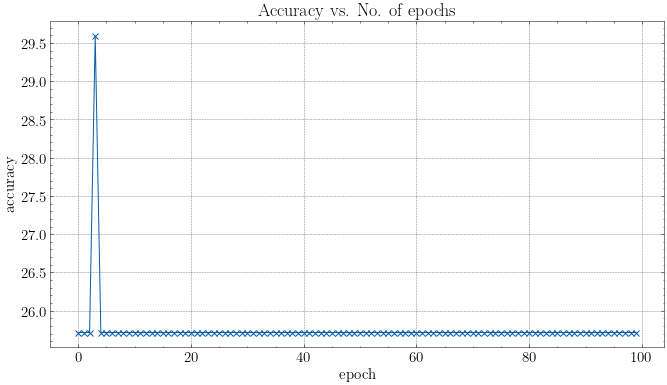

In [536]:
def plot_accuracies(history):
    """
     Plot the val accuracy in each epoch
    Args:
        history (Dictionary of np array): accumulative diccionary with train and val losses and accuracies
    Returns:
        None
    """
    plt.rcParams['figure.figsize']=[11,6]
    plt.rcParams.update({'font.size': 15})

    plt.plot(history['val_acc'], '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)


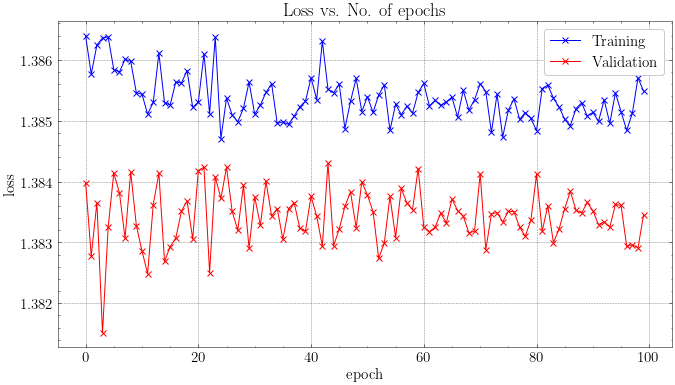

In [537]:

def plot_losses(history):
    """
     Plot the train and val losses in each epoch
    Args:
        history (Dictionary of np array): accumulative diccionary with train and val losses, and accuracies
    Returns:
        None
    """
    plt.rcParams['figure.figsize']=[11,6]
    plt.rcParams.update({'font.size': 15})
    
    plt.plot(history['loss'], '-bx')
    plt.plot(history['val_loss'],  '-rx')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

Finally the model will be test on the test dataset. Don not run until the end

In [ ]:
# Test model
# for epoch in range(num_epochs):
#     test_loss, test_correct = valid_epoch(model, device, test_loader, criterion)

#     test_loss = val_loss / len(val_loader.sampler)
#     test_acc = test_correct / len(val_loader.sampler) * 100
    
#     print("Epoch:{}/{} || Test Loss:{:.3f} ||Test Acc {:.2f} % ".format(epoch + 1, test_loss,test_acc) 



# 4. Report / Conclusions

- Solution Implemented
    - The accuracy of the CNN result was : 25.71 %
    - 1D approach was developed
    - Model was build with layers:
        - ReLU(Conv) + MaxPool 
    - The Dropout was implemented but due to the underfit model, it is not a good idea. We want to make the model more complex 
   
 - Conclusions
     - The model need to be improved because is a underfit model (See the losses graph, the validation curve is under the training curve and the accuracy is constant, no change):
    - The network need to be more complex
    - The 1 dimension approach could be changed by a 2D apporach and analyze the signal similas as images
    - Some studies suggest Multi-layer CNNs, important to explore
    - Data Augmentation (Create more data with Noise)
    - Try to run the model with the data without processing
 
    - For this specific case the precision and the accuracy are the metrics more relevant
    - The analysis done with the whole signal without shortening from -0.15s until 1.8 must be explored
    - Removal of artifact should be consider in a future stage of the improvement of the solution

- Challenges faced
    - Getting familiar with the format of the data
    - Tunning the model was a long process. I first start with small layers and increased gradually. Without a lot of sucess
    - The test dataset was not used because of hte low score at the val dataset
    - I need more time :)


Thanks